# DKRZ Python visualization

## How to plot pre-projected stereographic data

----

```
Copyright 2022 Deutsches Klimarechenzentrum GmbH (DKRZ)
Licensed under CC-BY-NC-SA-4.0
```

----

<img src="../../images/plot_pre-projected_data_scale_0.98.png" alt="Pre-projection scale_factor=0.98" align="right" width="30%">


There is not always the need to regrid the data to a rectilinear lonlat grid before plotting. Cartopy provides multiple projections which can be used to plot the data on a map using its native grid.

In this example we demonstrate how to read and plot the pre-projected polar-stereographic permafrost data from <a href="https://climate.esa.int/en/odp/#/project/permafrost"><b>ESA CCI</b></a> (ESA Climate Change Initiative). The coordinates **x** and **y** are in **meters** instead of lon-lat degrees and therefore we can use the <a href="https://proj.org/index.html"><b>PROJ</b></a> (a generic coordinate transformation software) parameters to specify the map projection as precisely as possible.

    Number of cells:  ~152.8 million
    Variable:         ALT(time:1, x:14762, y:10353)

**Content**
- Open the dataset
- Read the projection information
- Create the globe
  - 1. Plot with `scale_factor = 1`
  - 2. Plot with `scale_factor = 0.98`
  - 3. Make it faster

**Used packages**
- xarray
- python-cdo
- matplotlib
- cartopy
- pandas
- numpy
- datashader

**Data download**<br>
<a href="https://data.ceda.ac.uk/neodc/esacci/permafrost/data/active_layer_thickness/L4/area4/pp/v03.0/"> data.ceda.ac.uk </a>

<br>


In [1]:
import os, time
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cdo import Cdo
cdo = Cdo()

<br>

## Open the dataset

The data is stored in a netCDF file that can be easily loaded with **Xarray's** `open_dataset()` method.

In [2]:
infile = os.environ['HOME']+\
         '/CDO/Support/projections/ESACCI-PERMAFROST-L4-ALT-MODISLST_CRYOGRID-AREA4_PP-2003-fv03.0.nc'

In [3]:
ds = xr.open_dataset(infile)
ds

<xarray.Dataset>
Dimensions:              (time: 1, x: 14762, y: 10353)
Coordinates:
  * time                 (time) datetime64[ns] 2003-01-01
  * x                    (x) float64 -6.111e+06 -6.111e+06 ... 7.566e+06
  * y                    (y) float64 4.115e+06 4.114e+06 ... -5.478e+06
Data variables:
    polar_stereographic  int32 ...
    ALT                  (time, y, x) float32 ...
Attributes: (12/40)
    title:                      CCI Permafrost active layer thickness
    institution:                University of Oslo
    source:                     MODIS MOD11A1 and MYD11A1 level 3 Collection ...
    history:                    2021-02-24 10:28:09
    references:                 http://cci.esa.int/Permafrost, https://doi.or...
    tracking_id:                5eef2210-7c02-4954-9eea-051a1fd0e672
    ...                         ...
    geospatial_lat_units:       none
    geospatial_lon_units:       none
    geospatial_lon_resolution:  variable
    geospatial_lat_resolution:  variable
    key_variables:              permafrost active layer thickness
    format_version:             CCI Data Standards v2.2

Assign a varaible _var_ to the data variable _ALT_.

In [4]:
var = ds.ALT
var

<xarray.DataArray 'ALT' (time: 1, y: 10353, x: 14762)>
[152830986 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01
  * x        (x) float64 -6.111e+06 -6.111e+06 -6.11e+06 ... 7.566e+06 7.566e+06
  * y        (y) float64 4.115e+06 4.114e+06 4.113e+06 ... -5.477e+06 -5.478e+06
Attributes:
    standard_name:  permafrost_active_layer_thickness
    grid_mapping:   polar_stereographic
    units:          metres
    conversion:     to metres: x*0.01
    valid_min:      0
    valid_max:      10000
    actual_min:     0.01
    actual_max:     100.0

In [5]:
print('Number of cells: ', (len(ds.x) * len(ds.y)))
print('x: ', ds.x.min().values, ds.x.units, '-', ds.x.max().values, ds.x.units)
print('y: ', ds.y.min().values, ds.y.units, '-', ds.y.max().values, ds.y.units)

Number of cells:  152830986
x:  -6111475.222394747 m - 7566442.7961601885 m
y:  -5477531.389151403 m - 4114895.094696621 m


<br>

## Read the projection information

Get more information about the grid from the file using **CDO's operator** `griddes`.

In [6]:
cdo.griddes(input=infile)

['#',
 '# gridID 1',
 '#',
 'gridtype  = projection',
 'gridsize  = 152830986',
 'xsize     = 14762',
 'ysize     = 10353',
 'xname     = x',
 'xlongname = "x coordinate of projection"',
 'xunits    = "m"',
 'yname     = y',
 'ylongname = "y coordinate of projection"',
 'yunits    = "m"',
 'xfirst    = -6111475.22239475',
 'xinc      = 926.625433138333',
 'yfirst    = 4114895.09469662',
 'yinc      = -926.625433138333',
 'grid_mapping = polar_stereographic',
 'grid_mapping_name = polar_stereographic',
 'straight_vertical_longitude_from_pole = 0.',
 'false_easting = 0.',
 'false_northing = 0.',
 'latitude_of_projection_origin = 90.',
 'standard_parallel = 71.',
 'longitude_of_prime_meridian = 0.',
 'semi_major_axis = 6378137.',
 'inverse_flattening = 298.257223563',
 'crs_wkt = \'PROJCS["WGS 84 / Arctic Polar Stereographic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8

<br>

The Proj parameters for the stereographic grid.

In [7]:
proj_params = "+proj=stere +lat_0=90 +lat_ts=71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

To make it a bit more handy we create a dictionary from the PROJ parameter list.

In [8]:
p = proj_params.split(' ')

pdict = {}
for i,s in enumerate(p):
    if i < len(p)-1:
        pdict[s[1:].split('=')[0]] = s.split('=')[1]
#pdict

<br>

## Create the globe

Create the globe used to define the stereographic projection.


In [9]:
globe = ccrs.Globe(datum=pdict['datum'], 
                   #ellipse='WGS84', 
                   semimajor_axis=6378137.,
                   inverse_flattening=298.257223563)

### Conversion factor pixel in inches

In [10]:
px = 1/plt.rcParams['figure.dpi']

<br>

### 1. Plot with `scale_factor = 1` 

<img src="../../images/plot_pre-projected_data_scale_1.png" alt="Pre-projection scale_factor=1.0" align="right" width="30%">

This computation takes some time (~169 s) using pcolormesh.

The first plot is created by the given values for the projection. But here you can see that the data is not drawn exactly fitting the coastlines. This is often due to a rounding error of the scale_factor. The scale_factor given by the file is 1, but we have to decrease it a bit to put the data to the correct locations.

The following cell is of type `Raw` which means it won't be executed when you run the cell. To run the cell change the cell type to `Code`.

169.1090841293335 s


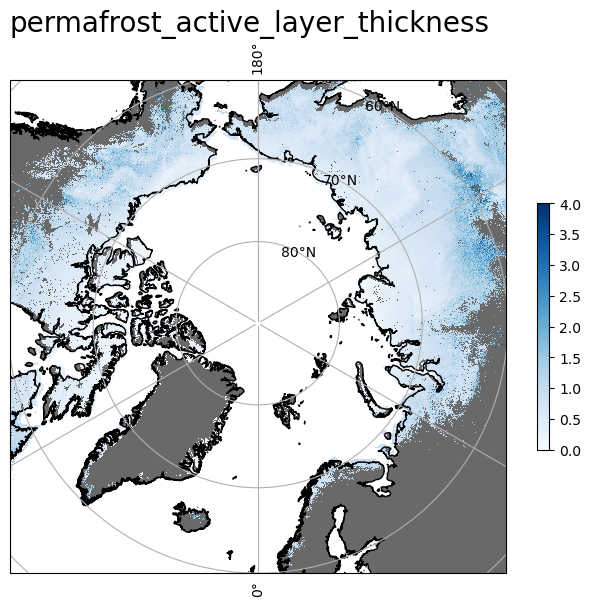

In [16]:
# Note: this takes some time!

t1 = time.time()

projection = ccrs.Stereographic(central_longitude=float(pdict['lon_0']), 
                                central_latitude=float(pdict['lat_0']),
                                false_easting=float(pdict['x_0']),
                                false_northing=float(pdict['y_0']), 
                                scale_factor=float(pdict['k']),
                                globe=globe)

fig, ax = plt.subplots(figsize=(800*px, 800*px), subplot_kw=dict(projection=projection))

ax.set_extent([0,360,60,90], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='dimgray')
#ax.add_feature(cfeature.OCEAN, facecolor='gainsboro')
ax.gridlines(draw_labels=True)
ax.coastlines(resolution='10m')
ax.set_title(var.standard_name, fontsize=20, loc='left')

plot = ax.pcolormesh(ds.x, ds.y, var[0,:,:], 
                     vmin=0,
                     vmax=4,
                     cmap='Blues')

cbar = plt.colorbar(plot, ax=ax, shrink=0.4)

fig.savefig('./plots/plot_pre-projected_data_scale_1.png', bbox_inches='tight')

t2 = time.time()
res = t2-t1
print(res, 's')

<br>

### 2. Plot with `scale_factor = 0.98` 

<img src="../../images/plot_pre-projected_data_scale_0.98.png" alt="Pre-projection scale_factor=0.98" align="right" width="30%">

This computation takes some time (~182 s) using pcolormesh.

The following cell is of type `Raw` which means it won't be executed when you run the cell. To run the cell switch the cell type to `Code`.

182.56025910377502 s


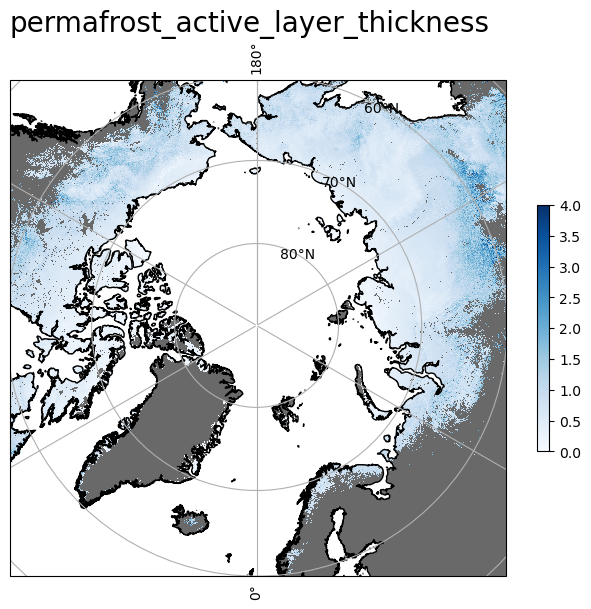

In [17]:
# Note: this takes some time!

t1 = time.time()

projection = ccrs.Stereographic(central_longitude=float(pdict['lon_0']), 
                                central_latitude=float(pdict['lat_0']),
                                false_easting=float(pdict['x_0']),
                                false_northing=float(pdict['y_0']), 
                                scale_factor=0.98,
                                globe=globe)

fig, ax = plt.subplots(figsize=(800*px, 800*px), subplot_kw=dict(projection=projection))

ax.set_extent([0,360,60,90], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='dimgray')
#ax.add_feature(cfeature.OCEAN, facecolor='gainsboro')
ax.gridlines(draw_labels=True)
ax.coastlines(resolution='10m')
ax.set_title(var.standard_name, fontsize=20, loc='left')

plot = ax.pcolormesh(ds.x, ds.y, var[0,:,:], 
                     vmin=0,
                     vmax=4,
                     cmap='Blues')

cbar = plt.colorbar(plot, ax=ax, shrink=0.4)

fig.savefig('./plots/plot_pre-projected_data_scale_0.98.png', bbox_inches='tight')

t2 = time.time()
res = t2-t1
print(res, 's')

<br>

### 3. Make it faster &#x1F32A;

<img src="../../images/plot_pre-projected_data_scale_0.98_datashader.png" alt="Pre-projection scale_factor=0.98 datashader" align="right" width="30%">

This computation takes only **10s** using **Datashader's** `dsshow` instead of pcolormesh.

<a href="https://datashader.org/index.html"> <b>Datashader</b></a> is a system to create images of large datasets very fast. 

Unfortunately, there aren't many tutorials on how to use Datashader with geo-referenced data and Matplotlib, but with a little bit of tinkering, the following script comes out taking less than a 10th of the runtime.

But of course it should be said that it is considerably faster, since we take a smaller number of x- and y-bins (1400, 1400), which can be specified with _plot_width_ and _plot_height_ in dsshow. Datashader puts the data into the appropriate bins resulting in a significant reduction in the number of data points that end up being drawn. The plot figure size for all plots are always 1400 pixel by 1400 pixel.

<!--
<img src="plot_pre-projected_data_scale_0.98_datashader.png" alt="Pre-projection scale_factor=0.98 datashader">
-->

<br>

In [18]:
import pandas as pd

import datashader as dsh
from datashader.mpl_ext import dsshow

First, we create a meshgrid for the used coordinates.

In [19]:
t, y, x = np.meshgrid(ds.time, ds.y, ds.x)

Next, we create a Pandas DataFrame containing the variable data and its coordinates. This step is needed to use for datashader's dsshow method.

In [20]:
t1 = time.time()

df = pd.DataFrame({'ALT':ds.ALT[0,:,:].squeeze().values.ravel(), 't':t.flatten(), 'y':y.flatten(), 'x':x.flatten()})#

t2 = time.time()
print((t2-t1), 's')

16.355087995529175 s


Now, we can generate the plot combining Matplotlib and the datashader artist.

<div class="alert alert-block alert-danger">
    <b>Note:</b> The ax.set_extent() call has to be moved down below the datashader dsshow call to zoom into the map.
</div>


9.484265804290771 s


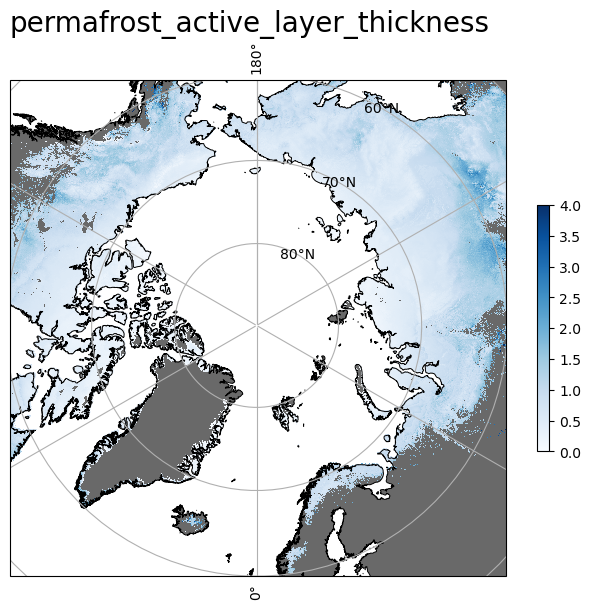

In [22]:
t1 = time.time()

projection = ccrs.Stereographic(central_longitude=float(pdict['lon_0']), 
                                central_latitude=float(pdict['lat_0']),
                                false_easting=float(pdict['x_0']),
                                false_northing=float(pdict['y_0']), 
                                scale_factor=0.98,
                                globe=globe)

fig, ax = plt.subplots(figsize=(800*px, 800*px), facecolor='white', subplot_kw={"projection": projection})

ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.7)
ax.add_feature(cfeature.LAND, facecolor='dimgray')
ax.gridlines(draw_labels=True)
ax.set_title(var.standard_name, fontsize=20, loc='left')

artist = dsshow(df,
                dsh.Point('x', 'y'),
                dsh.mean('ALT'),
                vmin=0,
                vmax=4,
                cmap='Blues',
                plot_width=1400,
                plot_height=1400,
                ax=ax)

cbar = plt.colorbar(artist, ax=ax, shrink=0.4)

ax.set_extent([0,360,60,90], ccrs.PlateCarree())

fig.savefig('./plots/plot_pre-projected_data_scale_0.98_datashader.png', bbox_inches='tight')

t2 = time.time()
res = t2-t1
print(res, 's')

Yes, that is much faster. &#x1F44D;